# German Traffic Sign Recognition Benchmark (GTSRB)
## AI-Powered Traffic Sign Classification for Autonomous Driving

**Course:** CS5100 - AI Applications  
**Framework:** PyTorch (CPU/GPU Compatible)

### Problem Statement and Significance

Traffic sign recognition is critical for autonomous driving and driver assistance systems. This project addresses the real-world challenge of accurately identifying traffic signs in real-time, which is essential for:

- **Road Safety**: Ensuring vehicles follow traffic regulations
- **Autonomous Navigation**: Enabling self-driving cars to obey traffic rules
- **Driver Assistance**: Providing warnings and guidance to human drivers

### Literature Review

Recent advances in deep learning have revolutionized traffic sign recognition:
- CNN-based approaches have achieved remarkable accuracy
- Transfer learning with pre-trained models like ResNet
- Data augmentation techniques for improved generalization

### Project Objectives

1. Data Analysis and Preprocessing
2. Model Development using PyTorch Deep Learning
3. Performance Evaluation and Comparison
4. Real-world Application Demonstration

## 1. Setup and Data Loading

In [1]:
# Install required packages for GTSRB Traffic Sign Recognition
!pip install torch torchvision numpy pandas matplotlib seaborn opencv-python scikit-learn kagglehub tqdm Pillow

# Restart kernel if running in Google Colab
import sys
if 'google.colab' in sys.modules:
    print('Running in Google Colab - restarting runtime...')
    import os
    os.kill(os.getpid(), 9)

print('✅ All dependencies installed successfully!')
print('🚀 Ready to run the GTSRB Traffic Sign Recognition project!')


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
✅ All dependencies installed successfully!
🚀 Ready to run the GTSRB Traffic Sign Recognition project!


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Scikit-learn for evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Progress bar
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

PyTorch version: 1.12.0
Device: cpu


In [3]:
# Download the GTSRB dataset using kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

# Explore the downloaded dataset structure
def explore_dataset(path):
    print("Dataset structure:")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

explore_dataset(path)

Path to dataset files: /Users/jingjinglin/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1
Dataset structure:
1/
  Test.csv
  Meta.csv
  Train.csv
  Test/
    07488.png
    06796.png
    08963.png
    03836.png
    04181.png
    ... and 12626 more files
  Meta/
    8.png
    .~lock.ClassesInformation.ods#
    9.png
    14.png
    28.png
    ... and 40 more files
  Train/
    32/
      00032_00003_00026.png
      00032_00000_00006.png
      00032_00000_00012.png
      00032_00005_00009.png
      00032_00005_00021.png
      ... and 235 more files
    35/
      00035_00030_00024.png
      00035_00021_00003.png
      00035_00021_00017.png
      00035_00030_00018.png
      00035_00012_00011.png
      ... and 1195 more files
    34/
      00034_00013_00003.png
      00034_00002_00024.png
      00034_00013_00017.png
      00034_00002_00018.png
      00034_00001_00010.png
      ... and 415 more files
    33/
      00033_00020_00015.png
      00033_00020_00001

## 2. Data Exploration and PyTorch Dataset Creation

In [4]:
# Function to load images from folder structure
def load_images_from_folders(path, target_size=(32, 32)):
    """Load images from folder structure and create dataset"""
    
    images = []
    labels = []
    class_names = []
    
    # Find all subdirectories (each represents a class)
    for item in sorted(os.listdir(path)):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            class_names.append(item)
            
            # Load images from this class folder
            for img_file in os.listdir(item_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm')):
                    img_path = os.path.join(item_path, img_file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, target_size)
                            images.append(img)
                            labels.append(len(class_names) - 1)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Try to load images from different possible structures
possible_paths = [
    os.path.join(path, 'Train'),
    os.path.join(path, 'train'),
    os.path.join(path, 'GTSRB'),
    path
]

images, labels, class_names = None, None, None

for p in possible_paths:
    if os.path.exists(p):
        print(f"Trying to load images from: {p}")
        try:
            images, labels, class_names = load_images_from_folders(p)
            if len(images) > 0:
                print(f"Successfully loaded {len(images)} images from {len(class_names)} classes")
                break
        except Exception as e:
            print(f"Error loading from {p}: {e}")

if images is not None:
    print(f"\nDataset shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Number of classes: {len(class_names)}")

Trying to load images from: /Users/jingjinglin/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train
Successfully loaded 39209 images from 43 classes

Dataset shape: (39209, 32, 32, 3)
Labels shape: (39209,)
Number of classes: 43


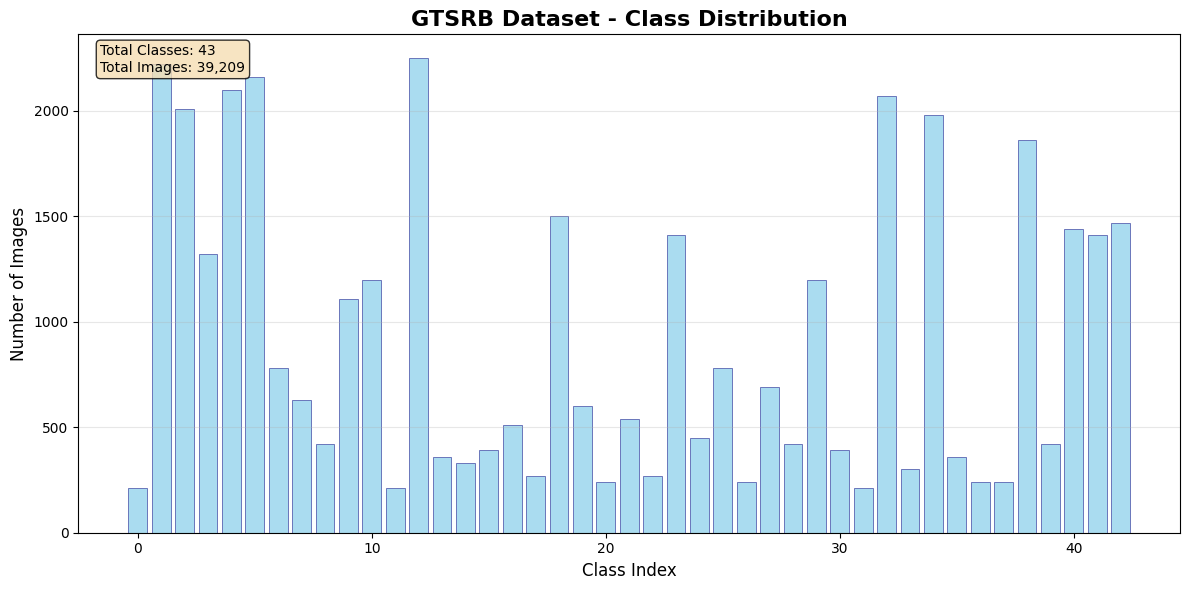

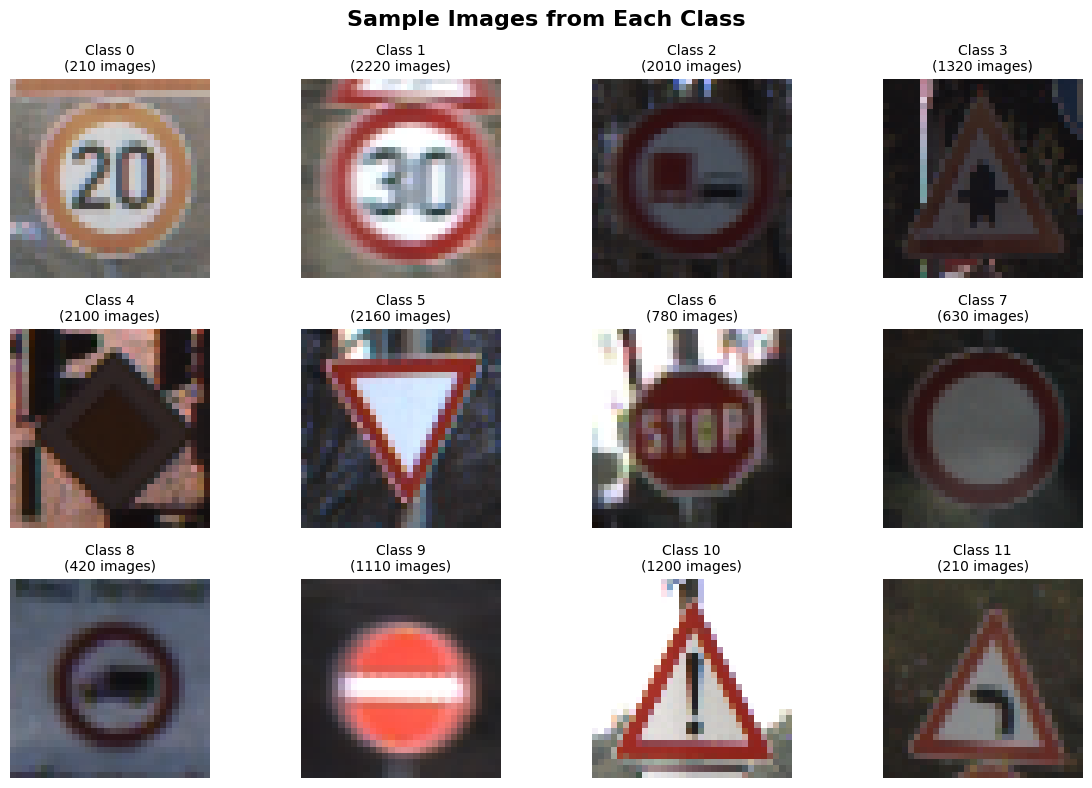


📊 Detailed Dataset Statistics:
Class    Count    Percentage  
------------------------------
0        210      0.54        %
1        2220     5.66        %
2        2010     5.13        %
3        1320     3.37        %
4        2100     5.36        %
5        2160     5.51        %
6        780      1.99        %
7        630      1.61        %
8        420      1.07        %
9        1110     2.83        %
... and 33 more classes


In [5]:
# Visualize the dataset
if labels is not None:
    unique, counts = np.unique(labels, return_counts=True)
    
    # Plot 1: Class distribution (standalone)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(unique)), counts, color='skyblue', alpha=0.7, edgecolor='navy', linewidth=0.5)
    plt.title('GTSRB Dataset - Class Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Class Index', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    plt.text(0.02, 0.98, f'Total Classes: {len(unique)}\nTotal Images: {len(images):,}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Sample images grid
    plt.figure(figsize=(12, 8))
    for i in range(min(12, len(unique))):
        class_indices = np.where(labels == unique[i])[0]
        if len(class_indices) > 0:
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[class_indices[0]])
            plt.title(f'Class {unique[i]}\n({counts[i]} images)', fontsize=10)
            plt.axis('off')
    
    plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\n📊 Detailed Dataset Statistics:")
    print(f"{'Class':<8} {'Count':<8} {'Percentage':<12}")
    print("-" * 30)
    for i, (cls, count) in enumerate(zip(unique[:10], counts[:10])):  # Show first 10
        percentage = (count / len(images)) * 100
        print(f"{cls:<8} {count:<8} {percentage:<12.2f}%")
    
    if len(unique) > 10:
        print(f"... and {len(unique) - 10} more classes")
        
else:
    print("❌ No data loaded for visualization!")

In [6]:
# Create PyTorch Dataset class
class GTSRBDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms
def get_transforms(target_size=(32, 32), augment=True):
    """Get transforms for training and validation"""
    
    if augment:
        # Training transforms with augmentation
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(target_size),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        # Validation transforms (no augmentation)
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    return transform

print("PyTorch Dataset class and transforms created!")

PyTorch Dataset class and transforms created!


## 3. Data Preprocessing and Model Definitions

In [7]:
# Split the data
def split_data(images, labels, test_size=0.2, val_size=0.2):
    """Split data into train, validation, and test sets"""
    
    # First split: train + temp, test
    X_temp, X_test, y_temp, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Second split: train, validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Apply preprocessing
if images is not None:
    # Split the data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(images, labels)
    
    # Create datasets
    train_transform = get_transforms(augment=True)
    val_transform = get_transforms(augment=False)
    
    train_dataset = GTSRBDataset(X_train, y_train, transform=train_transform)
    val_dataset = GTSRBDataset(X_val, y_val, transform=val_transform)
    test_dataset = GTSRBDataset(X_test, y_test, transform=val_transform)
    

    # Create data loaders (fixed for Jupyter notebook compatibility)
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    num_classes = len(np.unique(labels))

    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Number of classes: {num_classes}")
    print(f"Batch size: {batch_size}")
    print("Note: Using num_workers=0 for Jupyter notebook compatibility")


Training set: 25093 samples
Validation set: 6274 samples
Test set: 7842 samples
Number of classes: 43
Batch size: 32
Note: Using num_workers=0 for Jupyter notebook compatibility


In [8]:
# Define custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Transfer Learning with ResNet
def create_transfer_learning_model(num_classes):
    """Create a transfer learning model using ResNet18"""
    
    # Load pre-trained ResNet18
    model = models.resnet18(pretrained=True)
    
    # Freeze the base model
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    
    return model

# Create models
if 'num_classes' in locals():
    custom_model = CustomCNN(num_classes).to(device)
    transfer_model = create_transfer_learning_model(num_classes).to(device)
    
    print("Models created and moved to device!")
    print(f"Custom CNN parameters: {sum(p.numel() for p in custom_model.parameters()):,}")
    print(f"Transfer Learning parameters: {sum(p.numel() for p in transfer_model.parameters()):,}")

Models created and moved to device!
Custom CNN parameters: 1,480,907
Transfer Learning parameters: 11,462,251


## 4. Training Functions and Model Training

In [9]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001):
    """Train a PyTorch model"""
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 10
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for data, target in train_pbar:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()
        
        # Calculate average losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = 100. * train_correct / train_total
        val_accuracy = 100. * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [10]:
# Train the custom model
if 'custom_model' in locals() and 'train_loader' in locals():
    print("Training Custom CNN Model...")
    history_custom = train_model(custom_model, train_loader, val_loader, num_epochs=25)

Training Custom CNN Model...


Epoch 1/25 [Train]: 100%|██████████| 785/785 [01:38<00:00,  8.00it/s, Loss=0.3199, Acc=38.71%]


Epoch 1/25:
  Train Loss: 2.0472, Train Acc: 38.71%
  Val Loss: 0.8400, Val Acc: 71.55%


Epoch 2/25 [Train]: 100%|██████████| 785/785 [01:38<00:00,  7.99it/s, Loss=0.4193, Acc=76.07%]


Epoch 2/25:
  Train Loss: 0.7589, Train Acc: 76.07%
  Val Loss: 0.1815, Val Acc: 94.76%


Epoch 3/25 [Train]: 100%|██████████| 785/785 [01:38<00:00,  7.99it/s, Loss=0.1477, Acc=87.71%]


Epoch 3/25:
  Train Loss: 0.3998, Train Acc: 87.71%
  Val Loss: 0.0927, Val Acc: 97.18%


Epoch 4/25 [Train]: 100%|██████████| 785/785 [01:37<00:00,  8.04it/s, Loss=2.5732, Acc=91.42%]


Epoch 4/25:
  Train Loss: 0.2789, Train Acc: 91.42%
  Val Loss: 0.0502, Val Acc: 98.36%


Epoch 5/25 [Train]: 100%|██████████| 785/785 [01:37<00:00,  8.03it/s, Loss=0.0720, Acc=93.27%]


Epoch 5/25:
  Train Loss: 0.2194, Train Acc: 93.27%
  Val Loss: 0.0257, Val Acc: 99.35%


Epoch 6/25 [Train]: 100%|██████████| 785/785 [01:37<00:00,  8.08it/s, Loss=0.4193, Acc=94.29%]


Epoch 6/25:
  Train Loss: 0.1828, Train Acc: 94.29%
  Val Loss: 0.0259, Val Acc: 99.20%


Epoch 7/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.10it/s, Loss=0.0264, Acc=95.44%]


Epoch 7/25:
  Train Loss: 0.1535, Train Acc: 95.44%
  Val Loss: 0.0512, Val Acc: 98.14%


Epoch 8/25 [Train]: 100%|██████████| 785/785 [01:37<00:00,  8.04it/s, Loss=0.2805, Acc=95.85%]


Epoch 8/25:
  Train Loss: 0.1336, Train Acc: 95.85%
  Val Loss: 0.0213, Val Acc: 99.30%


Epoch 9/25 [Train]: 100%|██████████| 785/785 [01:37<00:00,  8.08it/s, Loss=0.0022, Acc=96.37%]


Epoch 9/25:
  Train Loss: 0.1224, Train Acc: 96.37%
  Val Loss: 0.0122, Val Acc: 99.65%


Epoch 10/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.12it/s, Loss=0.4807, Acc=96.48%]


Epoch 10/25:
  Train Loss: 0.1127, Train Acc: 96.48%
  Val Loss: 0.0094, Val Acc: 99.73%


Epoch 11/25 [Train]: 100%|██████████| 785/785 [01:37<00:00,  8.06it/s, Loss=0.0131, Acc=97.02%]


Epoch 11/25:
  Train Loss: 0.0957, Train Acc: 97.02%
  Val Loss: 0.0125, Val Acc: 99.57%


Epoch 12/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.12it/s, Loss=0.0034, Acc=96.92%]


Epoch 12/25:
  Train Loss: 0.0999, Train Acc: 96.92%
  Val Loss: 0.0074, Val Acc: 99.78%


Epoch 13/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.13it/s, Loss=0.1189, Acc=97.37%]


Epoch 13/25:
  Train Loss: 0.0839, Train Acc: 97.37%
  Val Loss: 0.0094, Val Acc: 99.68%


Epoch 14/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.11it/s, Loss=0.0082, Acc=97.51%]


Epoch 14/25:
  Train Loss: 0.0799, Train Acc: 97.51%
  Val Loss: 0.0096, Val Acc: 99.70%


Epoch 15/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.14it/s, Loss=0.0292, Acc=97.57%]


Epoch 15/25:
  Train Loss: 0.0779, Train Acc: 97.57%
  Val Loss: 0.0100, Val Acc: 99.63%


Epoch 16/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.14it/s, Loss=0.1999, Acc=97.89%]


Epoch 16/25:
  Train Loss: 0.0714, Train Acc: 97.89%
  Val Loss: 0.0178, Val Acc: 99.47%


Epoch 17/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.12it/s, Loss=0.0073, Acc=98.01%]


Epoch 17/25:
  Train Loss: 0.0703, Train Acc: 98.01%
  Val Loss: 0.0076, Val Acc: 99.76%


Epoch 18/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.11it/s, Loss=0.7367, Acc=97.94%]


Epoch 18/25:
  Train Loss: 0.0701, Train Acc: 97.94%
  Val Loss: 0.0127, Val Acc: 99.65%


Epoch 19/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.11it/s, Loss=0.3750, Acc=98.57%]


Epoch 19/25:
  Train Loss: 0.0465, Train Acc: 98.57%
  Val Loss: 0.0043, Val Acc: 99.87%


Epoch 20/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.09it/s, Loss=0.0003, Acc=98.67%]


Epoch 20/25:
  Train Loss: 0.0425, Train Acc: 98.67%
  Val Loss: 0.0031, Val Acc: 99.92%


Epoch 21/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.11it/s, Loss=0.0002, Acc=98.91%]


Epoch 21/25:
  Train Loss: 0.0367, Train Acc: 98.91%
  Val Loss: 0.0050, Val Acc: 99.79%


Epoch 22/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.10it/s, Loss=0.0206, Acc=98.95%]


Epoch 22/25:
  Train Loss: 0.0350, Train Acc: 98.95%
  Val Loss: 0.0045, Val Acc: 99.90%


Epoch 23/25 [Train]: 100%|██████████| 785/785 [01:37<00:00,  8.07it/s, Loss=0.1184, Acc=99.00%]


Epoch 23/25:
  Train Loss: 0.0353, Train Acc: 99.00%
  Val Loss: 0.0053, Val Acc: 99.82%


Epoch 24/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.12it/s, Loss=0.0222, Acc=99.05%]


Epoch 24/25:
  Train Loss: 0.0300, Train Acc: 99.05%
  Val Loss: 0.0038, Val Acc: 99.87%


Epoch 25/25 [Train]: 100%|██████████| 785/785 [01:36<00:00,  8.11it/s, Loss=0.3567, Acc=98.91%]


Epoch 25/25:
  Train Loss: 0.0344, Train Acc: 98.91%
  Val Loss: 0.0051, Val Acc: 99.86%


In [11]:
# Train the transfer learning model
if 'transfer_model' in locals() and 'train_loader' in locals():
    print("Training Transfer Learning Model...")
    history_transfer = train_model(transfer_model, train_loader, val_loader, num_epochs=15)

Training Transfer Learning Model...


Epoch 1/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 17.94it/s, Loss=3.5986, Acc=20.97%]


Epoch 1/15:
  Train Loss: 2.8368, Train Acc: 20.97%
  Val Loss: 2.3332, Val Acc: 33.84%


Epoch 2/15 [Train]: 100%|██████████| 785/785 [00:44<00:00, 17.82it/s, Loss=2.8485, Acc=24.85%]


Epoch 2/15:
  Train Loss: 2.6304, Train Acc: 24.85%
  Val Loss: 2.2601, Val Acc: 34.16%


Epoch 3/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 18.01it/s, Loss=3.9614, Acc=26.11%]


Epoch 3/15:
  Train Loss: 2.5739, Train Acc: 26.11%
  Val Loss: 2.2010, Val Acc: 35.80%


Epoch 4/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 18.05it/s, Loss=2.3800, Acc=27.01%]


Epoch 4/15:
  Train Loss: 2.5399, Train Acc: 27.01%
  Val Loss: 2.1475, Val Acc: 36.44%


Epoch 5/15 [Train]: 100%|██████████| 785/785 [00:44<00:00, 17.83it/s, Loss=2.1779, Acc=27.11%]


Epoch 5/15:
  Train Loss: 2.5197, Train Acc: 27.11%
  Val Loss: 2.1452, Val Acc: 37.12%


Epoch 6/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 17.93it/s, Loss=2.3752, Acc=27.11%]


Epoch 6/15:
  Train Loss: 2.5145, Train Acc: 27.11%
  Val Loss: 2.1230, Val Acc: 38.25%


Epoch 7/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 18.05it/s, Loss=3.7151, Acc=27.80%]


Epoch 7/15:
  Train Loss: 2.4880, Train Acc: 27.80%
  Val Loss: 2.0911, Val Acc: 38.41%


Epoch 8/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 17.98it/s, Loss=1.8145, Acc=28.60%]


Epoch 8/15:
  Train Loss: 2.4542, Train Acc: 28.60%
  Val Loss: 2.0837, Val Acc: 39.32%


Epoch 9/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 17.88it/s, Loss=3.2421, Acc=28.66%]


Epoch 9/15:
  Train Loss: 2.4556, Train Acc: 28.66%
  Val Loss: 2.0508, Val Acc: 39.66%


Epoch 10/15 [Train]: 100%|██████████| 785/785 [00:48<00:00, 16.27it/s, Loss=2.2254, Acc=28.40%]


Epoch 10/15:
  Train Loss: 2.4522, Train Acc: 28.40%
  Val Loss: 2.0376, Val Acc: 39.59%


Epoch 11/15 [Train]: 100%|██████████| 785/785 [00:44<00:00, 17.70it/s, Loss=3.0042, Acc=29.02%]


Epoch 11/15:
  Train Loss: 2.4374, Train Acc: 29.02%
  Val Loss: 2.0422, Val Acc: 40.28%


Epoch 12/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 17.85it/s, Loss=3.1165, Acc=28.90%]


Epoch 12/15:
  Train Loss: 2.4369, Train Acc: 28.90%
  Val Loss: 2.0262, Val Acc: 41.66%


Epoch 13/15 [Train]: 100%|██████████| 785/785 [00:44<00:00, 17.83it/s, Loss=3.7298, Acc=29.43%]


Epoch 13/15:
  Train Loss: 2.4162, Train Acc: 29.43%
  Val Loss: 2.0196, Val Acc: 40.17%


Epoch 14/15 [Train]: 100%|██████████| 785/785 [00:44<00:00, 17.66it/s, Loss=2.1101, Acc=29.92%]


Epoch 14/15:
  Train Loss: 2.4055, Train Acc: 29.92%
  Val Loss: 2.0427, Val Acc: 40.12%


Epoch 15/15 [Train]: 100%|██████████| 785/785 [00:43<00:00, 18.01it/s, Loss=2.8377, Acc=29.57%]


Epoch 15/15:
  Train Loss: 2.4010, Train Acc: 29.57%
  Val Loss: 1.9913, Val Acc: 41.19%


## 5. Model Evaluation and Visualization

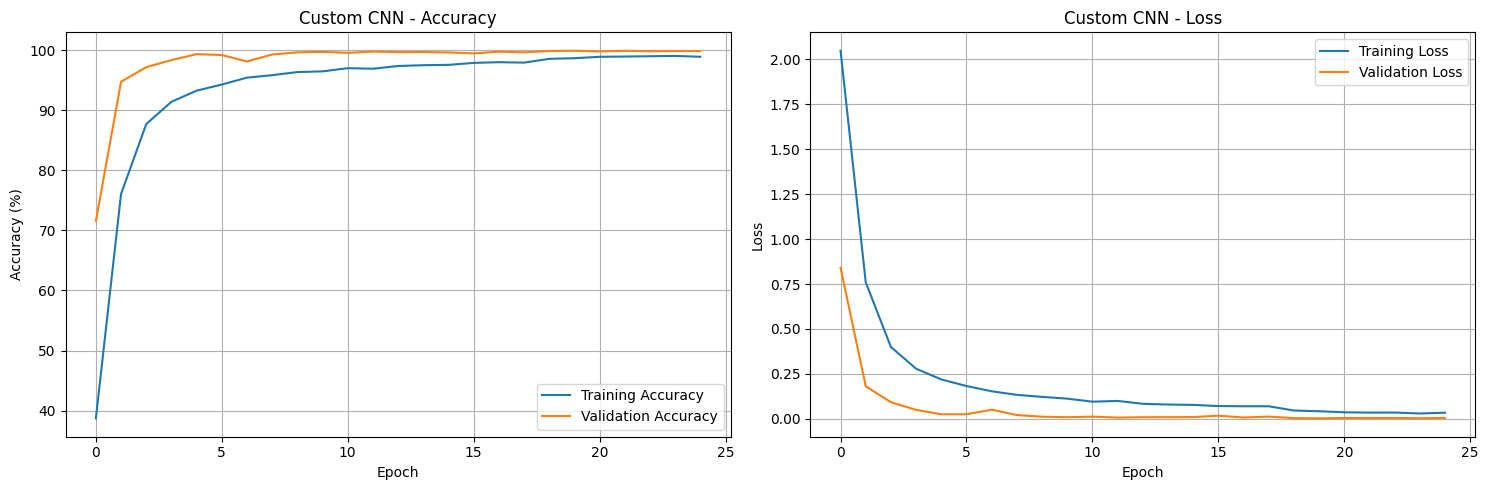

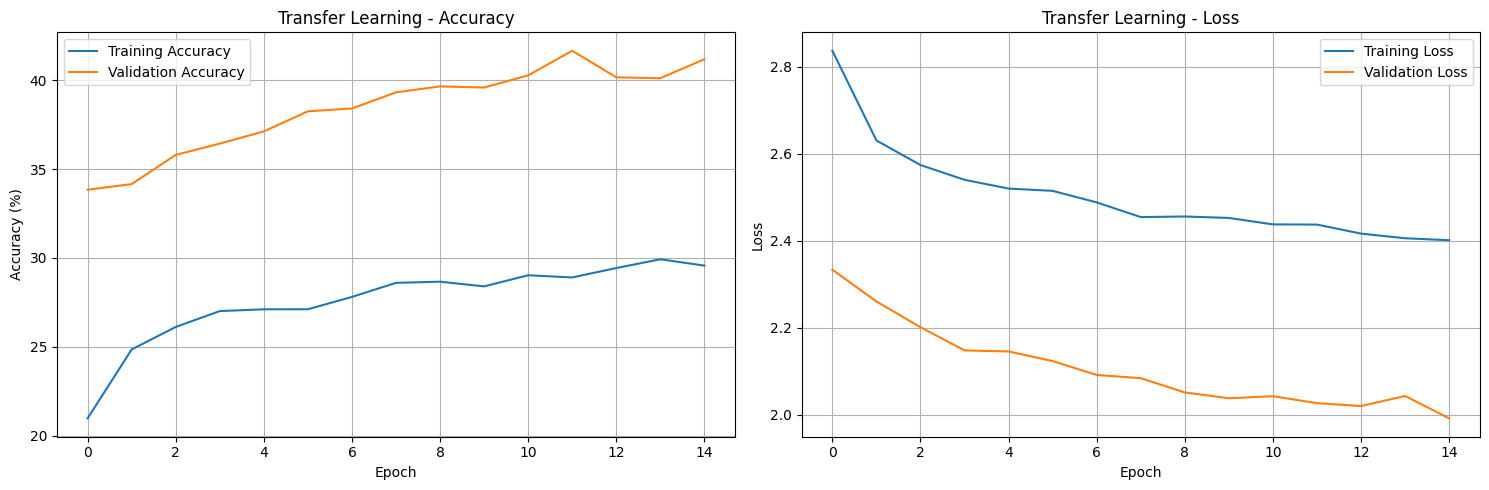

In [12]:
# Plot training history
def plot_training_history(history, title):
    """Plot training and validation metrics"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history['train_accuracies'], label='Training Accuracy')
    ax1.plot(history['val_accuracies'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history['train_losses'], label='Training Loss')
    ax2.plot(history['val_losses'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history for both models
if 'history_custom' in locals():
    plot_training_history(history_custom, 'Custom CNN')

if 'history_transfer' in locals():
    plot_training_history(history_transfer, 'Transfer Learning')

Evaluating Custom CNN: 100%|██████████| 246/246 [00:08<00:00, 29.13it/s]



Custom CNN Results:
Test Accuracy: 0.9991 (99.91%)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       444
           2       1.00      1.00      1.00       402
           3       1.00      1.00      1.00       264
           4       1.00      1.00      1.00       420
           5       1.00      1.00      1.00       432
           6       1.00      1.00      1.00       156
           7       1.00      1.00      1.00       126
           8       1.00      1.00      1.00        84
           9       1.00      1.00      1.00       222
          10       1.00      1.00      1.00       240
          11       1.00      1.00      1.00        42
          12       1.00      1.00      1.00       450
          13       1.00      1.00      1.00        72
          14       1.00      1.00      1.00        66
          15       1.00      1.00      1.00        78
     

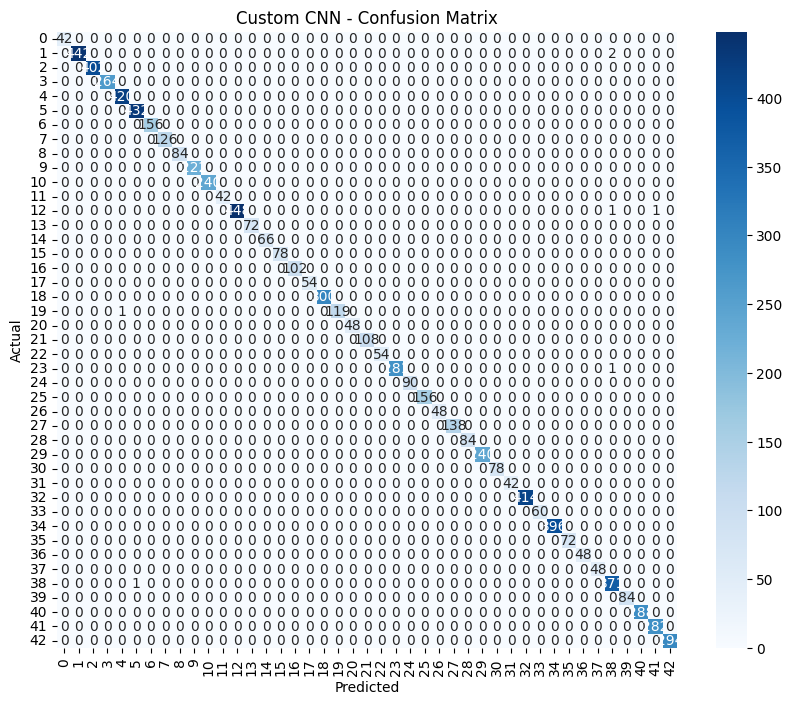

Evaluating Transfer Learning: 100%|██████████| 246/246 [00:10<00:00, 23.34it/s]



Transfer Learning Results:
Test Accuracy: 0.4146 (41.46%)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.40      0.54      0.46       444
           2       0.35      0.62      0.45       402
           3       0.37      0.39      0.38       264
           4       0.63      0.75      0.68       420
           5       0.68      0.71      0.70       432
           6       0.81      0.74      0.78       156
           7       0.55      0.75      0.63       126
           8       0.46      0.63      0.53        84
           9       0.63      0.83      0.72       222
          10       0.25      0.29      0.27       240
          11       0.43      0.07      0.12        42
          12       0.54      0.17      0.26       450
          13       0.50      0.07      0.12        72
          14       0.35      0.23      0.28        66
          15       0.44      0.09      0.15        7

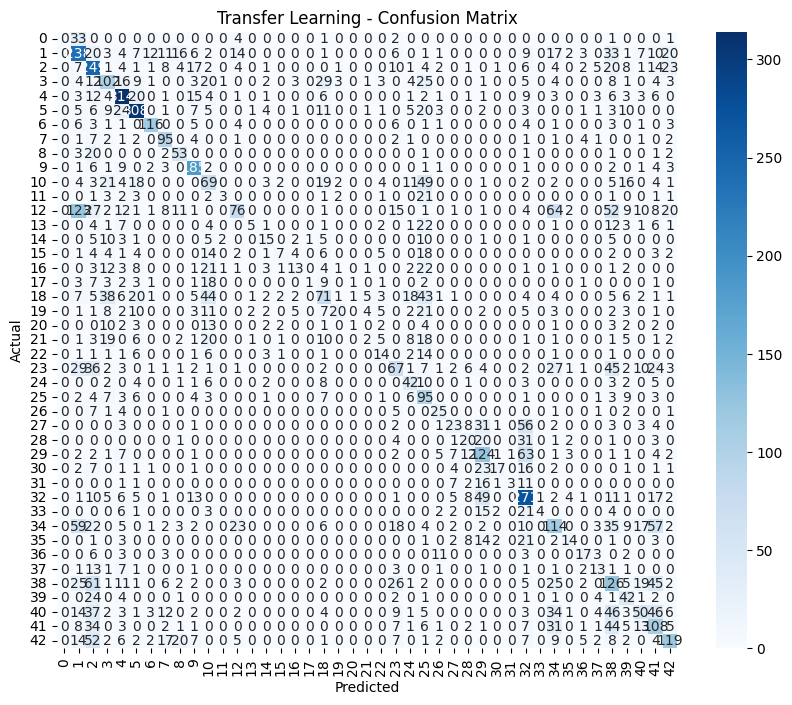

In [13]:
# Evaluate model function
def evaluate_model(model, test_loader, model_name):
    """Evaluate model performance on test set"""
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    
    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy

# Evaluate both models
if 'custom_model' in locals() and 'test_loader' in locals():
    custom_accuracy = evaluate_model(custom_model, test_loader, 'Custom CNN')

if 'transfer_model' in locals() and 'test_loader' in locals():
    transfer_accuracy = evaluate_model(transfer_model, test_loader, 'Transfer Learning')

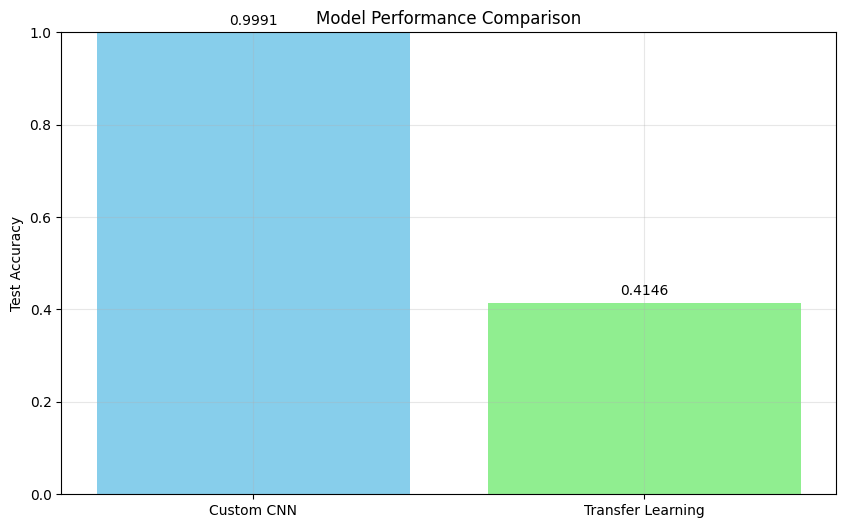


Model Performance Summary:
Custom CNN: 0.9991 (99.91%)
Transfer Learning: 0.4146 (41.46%)

Best performing model: Custom CNN


In [14]:
# Compare model performances (FIXED VERSION)
def compare_models():
    """Compare the performance of different models"""
    
    models_data = {}
    
    # Check if variables exist in globals()
    if 'custom_accuracy' in globals():
        models_data['Custom CNN'] = custom_accuracy
    
    if 'transfer_accuracy' in globals():
        models_data['Transfer Learning'] = transfer_accuracy
    
    if models_data:
        # Create comparison plot
        plt.figure(figsize=(10, 6))
        
        models = list(models_data.keys())
        accuracies = list(models_data.values())
        
        bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
        plt.title('Model Performance Comparison')
        plt.ylabel('Test Accuracy')
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Print summary
        print("\nModel Performance Summary:")
        for model, acc in models_data.items():
            print(f"{model}: {acc:.4f} ({acc*100:.2f}%)")
        
        best_model = max(models_data, key=models_data.get)
        print(f"\nBest performing model: {best_model}")
    else:
        print("❌ No model accuracies found!")
        print("Make sure you've run the evaluation cells first:")
        print("- custom_accuracy = evaluate_model(custom_model, test_loader, 'Custom CNN')")
        print("- transfer_accuracy = evaluate_model(transfer_model, test_loader, 'Transfer Learning')")

# Run the comparison
compare_models()

## 6. Real-World Application

In [15]:
# Function to predict traffic signs from new images
def predict_traffic_sign(model, image_path, class_names, target_size=(32, 32)):
    """Predict traffic sign from a new image"""
    
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    
    # Apply the same transforms as validation
    transform = get_transforms(augment=False)
    img_tensor = transform(img_resized).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    # Display results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title(f'Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    probs = probabilities[0].cpu().numpy()
    top_5_indices = np.argsort(probs)[-5:][::-1]
    top_5_probs = probs[top_5_indices]
    
    plt.bar(range(5), top_5_probs)
    plt.title(f'Top 5 Predictions')
    plt.xlabel('Class Index')
    plt.ylabel('Probability')
    plt.xticks(range(5), top_5_indices)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Predicted Class: {predicted_class}")
    if class_names and predicted_class < len(class_names):
        print(f"Class Name: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    
    return predicted_class, confidence

print("Traffic Sign Prediction Function Ready!")
print("To use this function, provide an image path and a trained model.")
print("Example: predict_traffic_sign(best_model, 'path/to/image.jpg', class_names)")

Traffic Sign Prediction Function Ready!
To use this function, provide an image path and a trained model.
Example: predict_traffic_sign(best_model, 'path/to/image.jpg', class_names)


In [16]:
# Model deployment analysis
def analyze_model_for_deployment(model, model_name):
    """Analyze model for deployment considerations"""
    
    # Get model size
    model_size = sum(p.numel() for p in model.parameters())
    
    # Test inference time
    import time
    model.eval()
    test_input = torch.randn(1, 3, 32, 32).to(device)
    
    # Warm up
    with torch.no_grad():
        for _ in range(10):
            _ = model(test_input)
    
    # Test inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = model(test_input)
    end_time = time.time()
    
    avg_inference_time = (end_time - start_time) / 100
    
    print(f"\n{model_name} Deployment Analysis:")
    print(f"Model Parameters: {model_size:,}")
    print(f"Model Size (MB): {model_size * 4 / (1024*1024):.2f}")
    print(f"Average Inference Time: {avg_inference_time*1000:.2f} ms")
    print(f"FPS: {1/avg_inference_time:.1f}")
    
    # Deployment recommendations
    print("\nDeployment Recommendations:")
    if avg_inference_time < 0.1:
        print("✓ Real-time capable (suitable for autonomous driving)")
    else:
        print("⚠ May need optimization for real-time applications")
    
    if model_size < 10000000:  # 10M parameters
        print("✓ Model size suitable for edge devices")
    else:
        print("⚠ Consider model compression for edge deployment")

# Analyze models for deployment
if 'custom_model' in locals():
    analyze_model_for_deployment(custom_model, 'Custom CNN')

if 'transfer_model' in locals():
    analyze_model_for_deployment(transfer_model, 'Transfer Learning')

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.



Custom CNN Deployment Analysis:
Model Parameters: 1,480,907
Model Size (MB): 5.65
Average Inference Time: 3.77 ms
FPS: 265.3

Deployment Recommendations:
✓ Real-time capable (suitable for autonomous driving)
✓ Model size suitable for edge devices

Transfer Learning Deployment Analysis:
Model Parameters: 11,462,251
Model Size (MB): 43.73
Average Inference Time: 5.76 ms
FPS: 173.7

Deployment Recommendations:
✓ Real-time capable (suitable for autonomous driving)
⚠ Consider model compression for edge deployment


## 7. Model predictions on sample images

Show Custom CNN results first - all 32 images in 8 rows of 4 images each
Show Transfer Learning results second - same layout
Print detailed statistics for each model separately
Provide a comparison summary at the end

CUSTOM CNN:


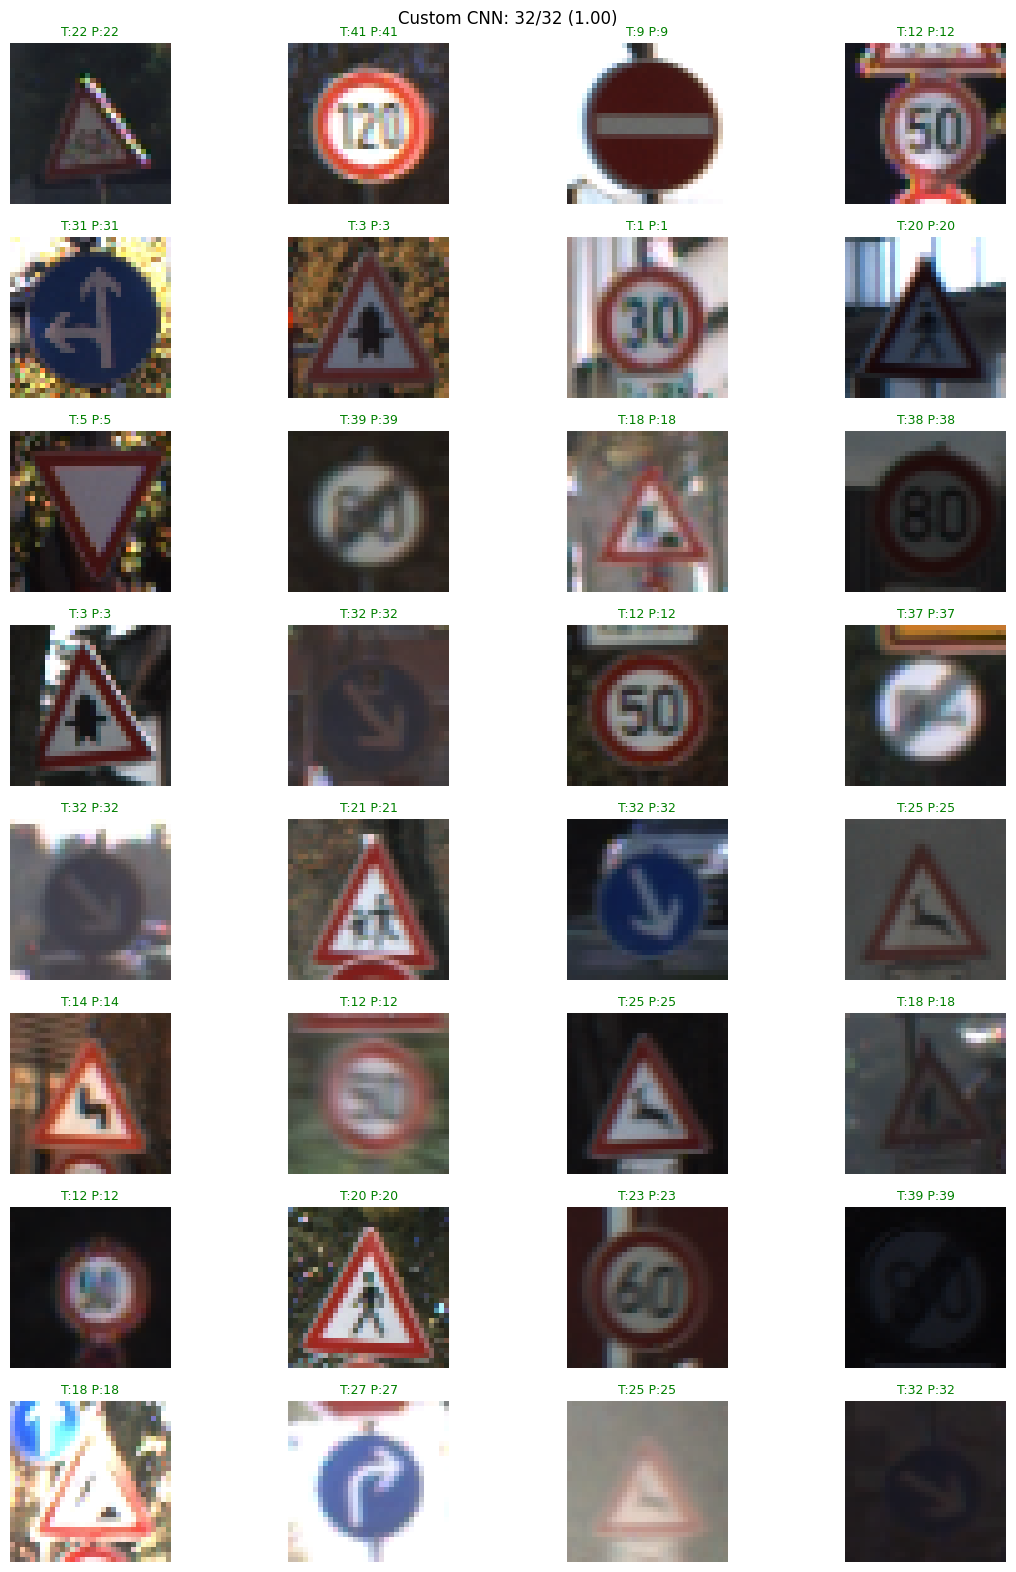

TRANSFER LEARNING:


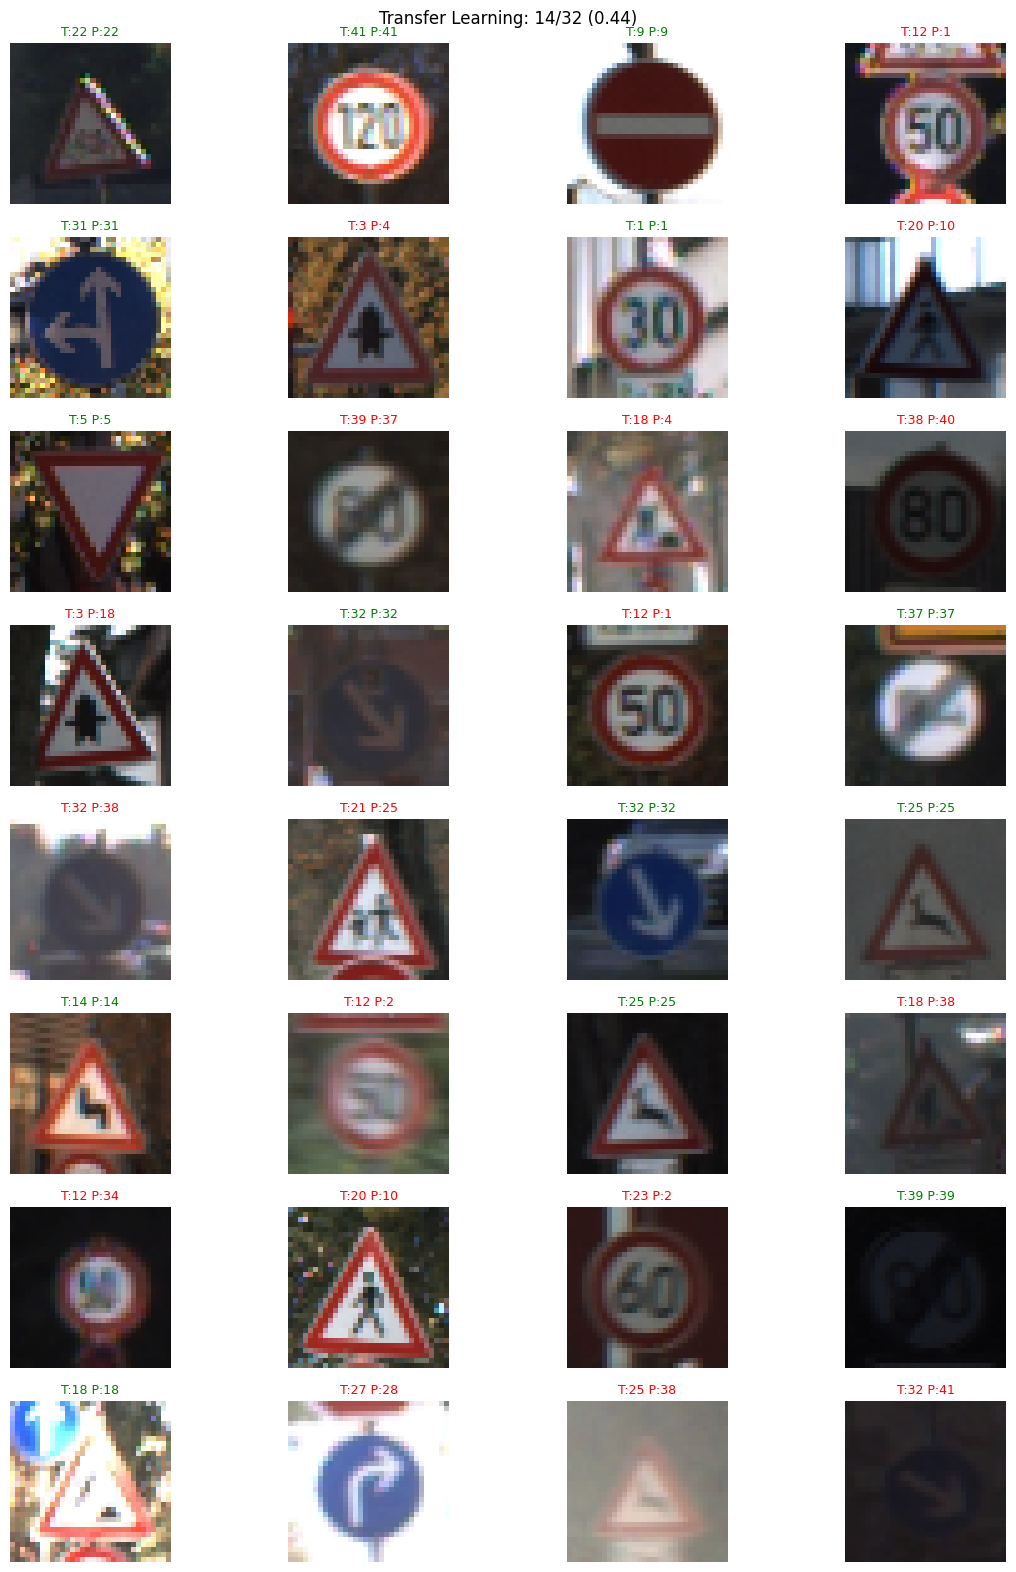

Summary: Custom 32/32 | Transfer 14/32 | Agreement 14/32


In [24]:
# visualization for both models (4 per row)
def viz_both(custom_model, transfer_model, test_loader):
    custom_model.eval()
    transfer_model.eval()
    device = next(custom_model.parameters()).device
    
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    n = len(data)
    
    with torch.no_grad():
        custom_pred = custom_model(data).argmax(dim=1)
        transfer_pred = transfer_model(data).argmax(dim=1)
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    
    rows = (n + 3) // 4  # 4 per row
    
    # Custom CNN
    print("CUSTOM CNN:")
    fig, axes = plt.subplots(rows, 4, figsize=(12, rows * 2))
    axes = axes.ravel() if rows > 1 else [axes] if rows == 1 else axes
    
    custom_correct = 0
    for i in range(n):
        img = (data[i] * std + mean).clamp(0, 1).cpu().permute(1, 2, 0)
        correct = custom_pred[i] == target[i]
        if correct: custom_correct += 1
        
        axes[i].imshow(img)
        axes[i].set_title(f'T:{target[i].item()} P:{custom_pred[i].item()}', 
                         color='green' if correct else 'red', fontsize=9)
        axes[i].axis('off')
    
    for i in range(n, len(axes)): axes[i].axis('off')
    
    plt.suptitle(f'Custom CNN: {custom_correct}/{n} ({custom_correct/n:.2f})')
    plt.tight_layout()
    plt.show()
    
    # Transfer Learning
    print("TRANSFER LEARNING:")
    fig, axes = plt.subplots(rows, 4, figsize=(12, rows * 2))
    axes = axes.ravel() if rows > 1 else [axes] if rows == 1 else axes
    
    transfer_correct = 0
    for i in range(n):
        img = (data[i] * std + mean).clamp(0, 1).cpu().permute(1, 2, 0)
        correct = transfer_pred[i] == target[i]
        if correct: transfer_correct += 1
        
        axes[i].imshow(img)
        axes[i].set_title(f'T:{target[i].item()} P:{transfer_pred[i].item()}', 
                         color='green' if correct else 'red', fontsize=9)
        axes[i].axis('off')
    
    for i in range(n, len(axes)): axes[i].axis('off')
    
    plt.suptitle(f'Transfer Learning: {transfer_correct}/{n} ({transfer_correct/n:.2f})')
    plt.tight_layout()
    plt.show()
    
    # Summary
    agreement = (custom_pred == transfer_pred).sum().item()
    print(f"Summary: Custom {custom_correct}/{n} | Transfer {transfer_correct}/{n} | Agreement {agreement}/{n}")

# Run
viz_both(custom_model, transfer_model, test_loader)

## 8.  Future Work





### Future Work

1. **Model Optimization**:
   - Implement model quantization for edge deployment
   - Explore knowledge distillation techniques
   - Test on different hardware platforms

2. **Advanced Techniques**:
   - Implement attention mechanisms
   - Explore ensemble methods
   - Test with different architectures (EfficientNet, Vision Transformer)

3. **Real-world Testing**:
   - Test on real traffic sign images
   - Evaluate performance under different lighting conditions
   - Implement real-time video processing

### Impact and Applications

This work contributes to:

- **Autonomous Driving**: Improving safety and navigation capabilities
- **Driver Assistance**: Enhancing human driver support systems
- **Traffic Management**: Supporting intelligent transportation infrastructure
- **Research**: Advancing computer vision and deep learning techniques

The developed models can be integrated into various real-world applications, making roads safer and transportation more efficient.